# Data Analytics with High Performance Computing - Practical 3
## Data Cleaning in Parallel with Dask

### Learning outcomes - REWRITE!!!!!!

Practice some common techniques for data cleaning with Python, using functionality of the Pandas library.
*  Part 1 - (Practical2a.ipynb) reading data, data exploration, data typing, coercion.
*  Part 2 - (Practical2b.ipynb) dealing with unstructured data, pattern matching, regular expressions, handling missing data, more typing and coercion, standardisation.

### 1. Reading and cleaning data

Import Pandas and NumPy<br/>


In [1]:
import pandas as pd
import numpy as np

Import Dask dataframe

In [2]:
from dask import dataframe as dd

Other imports

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

#### Import and run a Dask Client
This runs a Dask Dashboard, which provides a visualisation of computations run by Dask. Running the cell below will start the client and produce a link that you can open for viewing during the practical.<br/>
Note: the use of the Dask Client is optional and carries its own CPU overhead, but is useful here for extra insight.

In [4]:
from dask.distributed import Client

client = Client(n_workers=36, threads_per_worker=2, memory_limit="12GB")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 36
Total threads: 72,Total memory: 402.33 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40459,Workers: 36
Dashboard: http://127.0.0.1:8787/status,Total threads: 72
Started: Just now,Total memory: 402.33 GiB
Comm: tcp://127.0.0.1:34109,Total threads: 2
Dashboard: http://127.0.0.1:42049/status,Memory: 11.18 GiB
Nanny: tcp://127.0.0.1:40351,


Note: for the link in the cell above to work, you will need to set up a tunnel like the one used for Jupyter Labs. This will be something like (from your local machine) `ssh <your_username>@login.cirrus.ac.uk -L 8787:<your_node>:8787` where 8787 is the port used by the Dask Dashboard<br>
Have a browse of the dashboard and familiarise yourself with the kinds of data it displays. To being with this will look like the image below.
* The top left panel shows the total memory usage (note the layout is dynamic, so yours may differ)
* Below that we have the memory usage per worker (we are using 2 workers)
* At the bottom left you can cycle through plots for "Processing", "CPU", "Occupancy" and "Data Transfer".
* The large plots on the left will show the Dask task queue (top) and the "Progress" (bottom).
![alt text](P3SS1.png "Dask Dashboard")

Fig. 1 - Dask Dashboard start screen.


In [39]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
!ls -l /work/m22oc/m22oc/shared/DAwHPC/practicals_data/P3/*2019.csv | wc -l

51


We can initialise a Dask DataFrame object that will contain the data from these 51 files.<br>
This allows us to access all 51 files simultaneously, as if we'd loaded them into 51 Pandas DataFrames.<br>
Watch your Dask Dashboard for activity when you run the cell below.

In [6]:
df = dd.read_csv('/work/m22oc/m22oc/shared/DAwHPC/practicals_data/P3/*2019.csv')

In [7]:
df

,DATE_TIME,SITE_ID,LWIN,LWOUT,SWIN,SWOUT,RN,PRECIP,PA,TA,WS,WD,Q,RH,SNOWD_DISTANCE_COR,UX,UY,UZ,G1,G2,TDT1_TSOIL,TDT1_VWC,TDT2_TSOIL,TDT2_VWC,TDT3_TSOIL,TDT3_VWC,TDT4_TSOIL,TDT4_VWC,TDT5_TSOIL,TDT5_VWC,TDT6_TSOIL,TDT6_VWC,TDT7_TSOIL,TDT7_VWC,TDT8_TSOIL,TDT8_VWC,TDT9_TSOIL,TDT9_VWC,TDT10_TSOIL,TDT10_VWC,STP_TSOIL2,STP_TSOIL5,STP_TSOIL10,STP_TSOIL20,STP_TSOIL50
npartitions=51,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


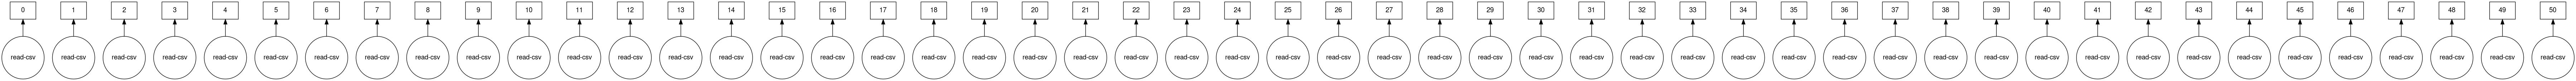

In [8]:
df.visualize()
# hint: double click the image to zoom in

As shown in the task graph above, the Dask DataFrame is divided up (partitioned) into 51 Pandas DataFrame objects (1 per CSV file). These will be read in through 51 parallel calls to dataframe.read_csv(). We'll leave it like that for now.

So, the DATE_TIME column is a date, the "SITE_ID" column is a string, and all of the measured data are floats.
We are also told there will be data missing for some sites as not all sites have all intrument types, and not all sites came online on the same starting date. Missing data have the value `-9999`.
This is clearly inconsistent - data that are present are floats and missing data are integers!

Let's say we want to study the soil surface temperature (mean of TDT1_TSOIL and TDT2_TSOIL) over time at all sites.

Instantiating a Dask DataFrame does not load the data, but constructs arrays ready to receive the data. We can see the column names and the data types.<br>
First, let's store the "DATE_TIME" column as a datetime64 object, rather than a general object.<br>
Remember, the DASK API builds on the Pandas API, where you may have come across the to_datetime() function.

In [9]:
df['DATE_TIME'] = dd.to_datetime(df['DATE_TIME'])
df

,DATE_TIME,SITE_ID,LWIN,LWOUT,SWIN,SWOUT,RN,PRECIP,PA,TA,WS,WD,Q,RH,SNOWD_DISTANCE_COR,UX,UY,UZ,G1,G2,TDT1_TSOIL,TDT1_VWC,TDT2_TSOIL,TDT2_VWC,TDT3_TSOIL,TDT3_VWC,TDT4_TSOIL,TDT4_VWC,TDT5_TSOIL,TDT5_VWC,TDT6_TSOIL,TDT6_VWC,TDT7_TSOIL,TDT7_VWC,TDT8_TSOIL,TDT8_VWC,TDT9_TSOIL,TDT9_VWC,TDT10_TSOIL,TDT10_VWC,STP_TSOIL2,STP_TSOIL5,STP_TSOIL10,STP_TSOIL20,STP_TSOIL50
npartitions=51,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


You may see some workers reporting "compute failed" at this point, in the terminal where you launched jupyter lab, and red blocks in the "Task Stream" of the Dask Dashboard window. We will address this later.

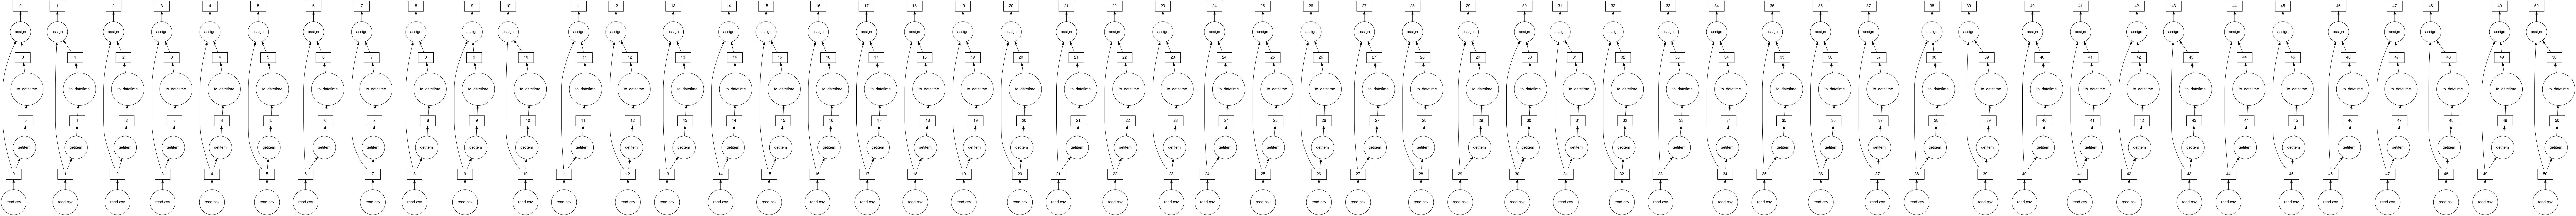

In [10]:
df.visualize()

We can now see a more complex task graph for each of the 51 objects being generated in parallel - now the coercion of the date columns is being done in parallel to the file being read.

Looking along the row of data types, there are a number of columns with `int64` data. Any attempts to view the data will result in compute errors due to this inconsistent data typing.
For example, `df.head()`. Note, this is wrapped in a `try...except` clause below to make the error easier to read:

In [11]:
try:
    df.head() # intentionally fails
except ValueError as ve:
    print(ve)

Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+--------------------+---------+----------+
| Column             | Found   | Expected |
+--------------------+---------+----------+
| SNOWD_DISTANCE_COR | float64 | int64    |
| TDT2_TSOIL         | float64 | int64    |
| TDT2_VWC           | float64 | int64    |
+--------------------+---------+----------+

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'SNOWD_DISTANCE_COR': 'float64',
       'TDT2_TSOIL': 'float64',
       'TDT2_VWC': 'float64'}

to the call to `read_csv`/`read_table`.

Alternatively, provide `assume_missing=True` to interpret
all unspecified integer columns as floats.


2022-10-28 09:47:46,977 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-a72072af236b27f2ecfacc890d8b8602', 0)
Function:  execute_task
args:      ((subgraph_callable-20127253-cdea-4573-a1c7-e99012c1a650, [(<function read_block_from_file at 0x14f5a1ebf040>, <OpenFile '/work/m22oc/m22oc/shared/DAwHPC/practicals_data/P3/COSMOS-UK_ALIC1_HydroSoil_SH_2013-2019.csv'>, 0, 24157118, b'\n'), None, True, True]))
kwargs:    {}
Exception: 'ValueError("Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.\\n\\n+--------------------+---------+----------+\\n| Column             | Found   | Expected |\\n+--------------------+---------+----------+\\n| SNOWD_DISTANCE_COR | float64 | int64    |\\n| TDT2_TSOIL         | float64 | int64    |\\n| TDT2_VWC           | float64 | int64    |\\n+--------------------+---------+----------+\\n\\nUsually this is due to dask\'s dtype inference failing, and\\n*may* be fixed by specifying dtypes manually by adding:\\n\\ndtype={\'SNOWD_DISTANCE_CO

This fails because the data types in some of the columns are inconsistent. Three columns, 'SNOWD_DISTANCE_COR', 'TDT2_TSOIL' and 'TDT2_VWC' are mentioned, but there may be more.<br>
Dask reports "expected" data types for these are `int64`, but `float64` values are found.

Let's take a step back and look at the metadata.

In [12]:
metadata = pd.read_csv('/work/m22oc/m22oc/shared/DAwHPC/practicals_data/P3/COSMOS-UK_HydroSoil_SH_2013-2019_Metadata.csv')
metadata

,VARIABLE_ID,VARIABLE_NAME,RESOLUTION,UNIT,AGGREGATION,DATA_TYPE,MISSING_VALUE
0,G1,Soil heat flux 1,30 Minute,Wm-2,Mean over preceding 30 mins,Floating Point,-9999
1,G2,Soil heat flux 2,30 Minute,Wm-2,Mean over preceding 30 mins,Floating Point,-9999
2,LWIN,Incoming longwave radiation,30 Minute,Wm-2,Mean over preceding 30 mins,Floating Point,-9999
3,LWOUT,Outgoing longwave radiation,30 Minute,Wm-2,Mean over preceding 30 mins,Floating Point,-9999
4,PA,Atmospheric pressure,30 Minute,hPa,Mean over preceding 30 mins,Floating Point,-9999
5,PRECIP,Precipitation,30 Minute,mm,Total over preceding 30 mins,Floating Point,-9999
6,Q,Absolute humidity,30 Minute,gm-3,Mean over preceding 30 mins,Floating Point,-9999
7,RH,Relative humidity,30 Minute,%,Mean over preceding 30 mins,Floating Point,-9999
8,RN,Net radiation,30 Minute,Wm-2,Mean over preceding 30 mins,Floating Point,-9999
9,SNOWD_DISTANCE_COR,Snow depth,30 Minute,mm,Instantaneous,Floating Point,-9999


So, the DATE_TIME column is a formatted date string, the "SITE_ID" column is a string, and all of the measured data are floats.<br>
We are also told (separately) there will be data missing for some sites as not all sites have all intrument types, and not all sites came online on the same starting date.<br>
Missing data have the value `-9999`.<br>
This is clearly inconsistent (compare the "DATA_TYPE" and "MISSING_DATA" columns) - data that are present are floats and missing data are integers!

Now take a look at a data file. A quick way to do this is to use the `head` Linux util:

In [13]:
!head /work/m22oc/m22oc/shared/DAwHPC/practicals_data/P3/COSMOS-UK_ALIC1_HydroSoil_SH_2013-2019.csv

DATE_TIME,SITE_ID,LWIN,LWOUT,SWIN,SWOUT,RN,PRECIP,PA,TA,WS,WD,Q,RH,SNOWD_DISTANCE_COR,UX,UY,UZ,G1,G2,TDT1_TSOIL,TDT1_VWC,TDT2_TSOIL,TDT2_VWC,TDT3_TSOIL,TDT3_VWC,TDT4_TSOIL,TDT4_VWC,TDT5_TSOIL,TDT5_VWC,TDT6_TSOIL,TDT6_VWC,TDT7_TSOIL,TDT7_VWC,TDT8_TSOIL,TDT8_VWC,TDT9_TSOIL,TDT9_VWC,TDT10_TSOIL,TDT10_VWC,STP_TSOIL2,STP_TSOIL5,STP_TSOIL10,STP_TSOIL20,STP_TSOIL50
2015-03-06T13:30:00Z,ALIC1,278.4,371.9,521.5,62.95,365.05,-9999,-9999,10.19,3.62,210.7,5.793,60.93,-9999,-9999,-9999,-9999,40.617,45.8,5.89,19.44,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,7.903,6.673,5.761,5.127,5.474
2015-03-06T14:00:00Z,ALIC1,275.9,373.0,526.0,63.06,365.84,0.0,1020.0,10.43,4.329,211.5,5.858,60.69,-9999,-9999,-9999,-9999,33.512,43.042,6.06,19.51,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,7.987,6.823,5.893,5.165,5.491
2015-03-06T14:30:00Z,ALIC1,275.5,373.0,489.8,58.98,333.32,0.0,1019.0,

The first file alphabetically has no-date values of `-9999` in the columns reported in the Dask error - we need to fix these!<br>
Dask has used the first row of data from the first CSV file to define data types for each column - the error arises when it finds a row of data that does not conform to expected data types.

Let's load the data again, but this time deal with missing data, coerce data types, and only load columns of data we don't need.

In [14]:
# a list of the columns we are interested in - we'll look at the air temperature and the soil temperature closest to the surface
cols = ['DATE_TIME','SITE_ID','TA','TDT1_TSOIL','TDT2_TSOIL'] # list of columns we're interested in
dtypes = {'DATE_TIME':object,'SITE_ID':str,'TA':np.float64,'TDT1_TSOIL':np.float64,'TDT2_TSOIL':np.float64} # datatypes dictionary
# Note: we read "DATE_TIME" as a general object, but pass this column to the "parse_dates" option.
df = dd.read_csv('/work/m22oc/m22oc/shared/DAwHPC/practicals_data/P3/*2019.csv', usecols=cols, dtype=dtypes, parse_dates=['DATE_TIME']).replace(-9999,np.nan)
df

,DATE_TIME,SITE_ID,TA,TDT1_TSOIL,TDT2_TSOIL
npartitions=51,,,,,
,"datetime64[ns, UTC]",object,float64,float64,float64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


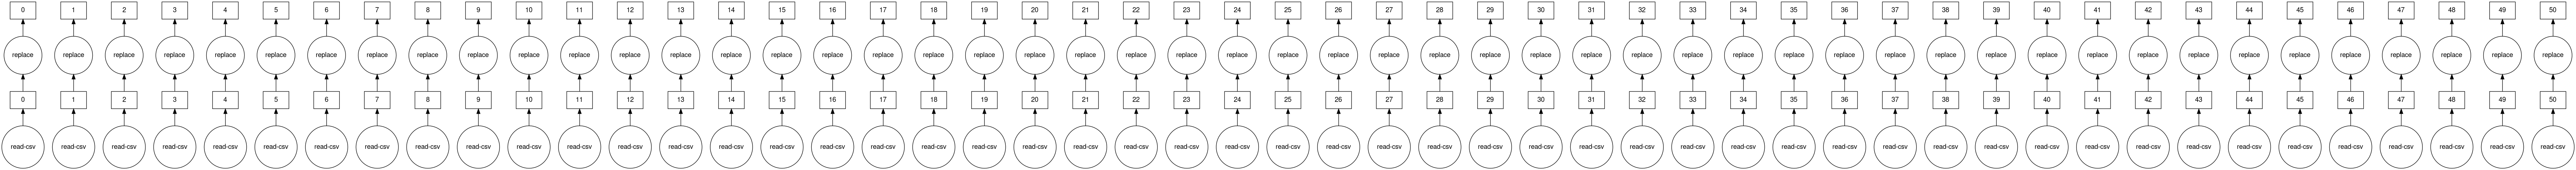

In [15]:
df.visualize()

What, if anything, is different about this task graph?

Now we can view the first few rows of the Dask DataFrame. Check the Dask Dashboard for activity.

In [16]:
%time df.head()

CPU times: user 208 ms, sys: 86.1 ms, total: 294 ms
Wall time: 1.08 s


,DATE_TIME,SITE_ID,TA,TDT1_TSOIL,TDT2_TSOIL
0,2015-03-06 13:30:00+00:00,ALIC1,10.19,5.89,NaN
1,2015-03-06 14:00:00+00:00,ALIC1,10.43,6.06,NaN
2,2015-03-06 14:30:00+00:00,ALIC1,10.61,6.23,NaN
3,2015-03-06 15:00:00+00:00,ALIC1,10.69,6.37,NaN
4,2015-03-06 15:30:00+00:00,ALIC1,10.39,6.46,NaN


We will now perform a simple task of viewing the temperature trend at each site over the lifetime of the data. SInce this is a timeseries type operation, it will be more efficient if we set the index of the dataframe to the "DATE_TIME" column.

In [17]:
%time df = df.set_index('DATE_TIME')

CPU times: user 919 ms, sys: 295 ms, total: 1.21 s
Wall time: 2.53 s


In [18]:
%time df.head()

CPU times: user 696 ms, sys: 191 ms, total: 887 ms
Wall time: 1.62 s


,SITE_ID,TA,TDT1_TSOIL,TDT2_TSOIL
DATE_TIME,,,,
2013-10-02 13:30:00+00:00,CHIMN,19.1,17.44,17.42
2013-10-02 14:00:00+00:00,CHIMN,NaN,NaN,NaN
2013-10-02 14:30:00+00:00,CHIMN,NaN,NaN,NaN
2013-10-02 15:00:00+00:00,CHIMN,NaN,NaN,NaN
2013-10-02 15:30:00+00:00,CHIMN,NaN,NaN,NaN


We can now, very quickly, run groupby() commands.
Here we group by 'SITE_ID' and show the 'ALIC1' group.

In [19]:
%time df.groupby('SITE_ID').get_group('ALIC1').compute()

CPU times: user 1.47 s, sys: 274 ms, total: 1.75 s
Wall time: 2.02 s


,SITE_ID,TA,TDT1_TSOIL,TDT2_TSOIL
DATE_TIME,,,,
2015-03-06 13:30:00+00:00,ALIC1,10.190,5.89,NaN
2015-03-06 14:00:00+00:00,ALIC1,10.430,6.06,NaN
2015-03-06 14:30:00+00:00,ALIC1,10.610,6.23,NaN
2015-03-06 15:00:00+00:00,ALIC1,10.690,6.37,NaN
2015-03-06 15:30:00+00:00,ALIC1,10.390,6.46,NaN
...,...,...,...,...
2019-12-31 22:00:00+00:00,ALIC1,6.203,6.89,6.73
2019-12-31 22:30:00+00:00,ALIC1,6.051,6.87,6.72
2019-12-31 23:00:00+00:00,ALIC1,5.881,6.84,6.70


Other SITE_ID values can be found with the `unique()` function.

In [20]:
%time site_ids = df['SITE_ID'].unique().compute()
site_ids

CPU times: user 1.34 s, sys: 217 ms, total: 1.56 s
Wall time: 2.02 s


0     CHIMN
1     SHEEP
2     WADDN
3     WYTH1
4     HOLLN
5     MORLY
6     GLENS
7     BALRD
8     HARTW
9     ROTHD
10    EASTB
11    GISBN
12    TADHM
13    NWYKE
14    LIZRD
15    PLYNL
16    STIPS
17    SOURH
18    COCLP
19    CRICH
20    MOORH
21    LULLN
22    PORTN
23    BUNNY
24    BICKL
25    RDMER
26    CHOBH
27    ALIC1
28    HARWD
29    CARDT
30    STGHT
31    HENFS
32    REDHL
33    EUSTN
34    LODTN
35    RISEH
36    HILLB
37    GLENW
38    CGARW
39    ELMST
40    HADLW
41    SPENF
42    FINCH
43    WRTTL
44    HYBRY
45    COCHN
46    HLACY
47    FIVET
48    MOREM
49    SYDLG
50    WIMPL
Name: SITE_ID, dtype: object

In the above, note the .compute() call at the end of the line.<br>
Without .compute(), the task graph is generated, but not computed.

In [21]:
alic1 = df.groupby('SITE_ID').get_group('ALIC1')

We can assign the resulting DataFrame to a variable and compute it separately.

In [22]:
type(alic1)

dask.dataframe.core.DataFrame

In [23]:
alic1.compute()

,SITE_ID,TA,TDT1_TSOIL,TDT2_TSOIL
DATE_TIME,,,,
2015-03-06 13:30:00+00:00,ALIC1,10.190,5.89,NaN
2015-03-06 14:00:00+00:00,ALIC1,10.430,6.06,NaN
2015-03-06 14:30:00+00:00,ALIC1,10.610,6.23,NaN
2015-03-06 15:00:00+00:00,ALIC1,10.690,6.37,NaN
2015-03-06 15:30:00+00:00,ALIC1,10.390,6.46,NaN
...,...,...,...,...
2019-12-31 22:00:00+00:00,ALIC1,6.203,6.89,6.73
2019-12-31 22:30:00+00:00,ALIC1,6.051,6.87,6.72
2019-12-31 23:00:00+00:00,ALIC1,5.881,6.84,6.70


The each time the Dask operations are computed, the data is being read from file.<br>
This is great if the files being analysed are too large for the available memory.<br>
However, if we do have enough memory, analysis will be a lot faster if the data is kept in memory!

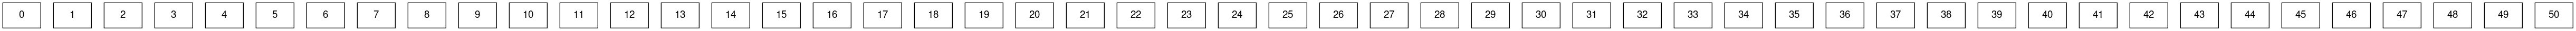

In [24]:
df2 = df.persist()
df2.visualize()

Note the calls to read_csv() are gone and, once computed, `df2` will be represented as 51 Pandas DataFrames in memory.

In [25]:
%time df2.groupby('SITE_ID')['TA'].mean().compute()
#Group by SITE_ID and compute the average air temperature
#Run this cell twice and observe the difference
#Depending on the filesystem, this may be orders of magnitude faster.

CPU times: user 1.39 s, sys: 291 ms, total: 1.68 s
Wall time: 2.15 s


SITE_ID
BALRD     8.880826
CHIMN    10.443856
GLENS     6.623934
HARTW     8.358973
HOLLN     9.924608
MORLY    10.680815
SHEEP     9.911862
WADDN    10.557415
WYTH1    10.458253
COCLP     8.848499
CRICH     9.182283
EASTB     8.381680
GISBN     8.329593
LIZRD    11.140881
NWYKE    10.282385
PLYNL     7.285601
ROTHD    10.583686
SOURH     8.041314
STIPS     7.924171
TADHM    10.774289
BUNNY    10.628194
LULLN    10.959323
MOORH     6.985737
PORTN    10.498931
ALIC1    10.927174
BICKL    10.048129
CHOBH    10.635571
RDMER    11.028771
CARDT    11.181747
HARWD     7.902479
STGHT    10.242394
HENFS     9.631647
REDHL    10.923675
EUSTN    10.907918
GLENW     8.332434
HILLB     9.554486
LODTN    10.261159
RISEH    10.676650
CGARW     9.691159
ELMST    10.647160
HADLW    10.720809
SPENF     9.969199
FINCH    11.172987
WRTTL    11.255351
COCHN     8.303823
HYBRY    10.058990
HLACY    11.543561
FIVET     9.393436
MOREM    10.020592
SYDLG     9.746100
WIMPL     8.828801
Name: TA, dtype: float6

CPU times: user 3.5 s, sys: 373 ms, total: 3.87 s
Wall time: 4.06 s


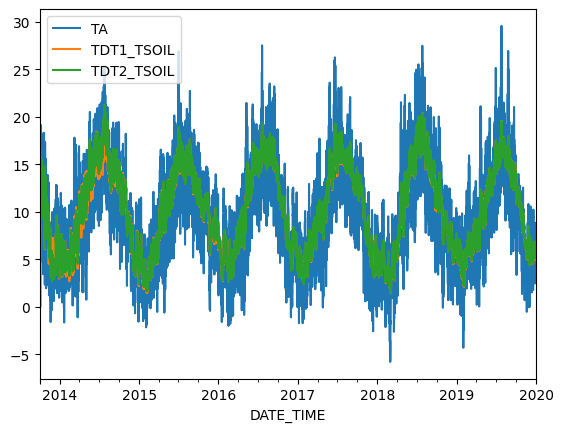

In [26]:
%time ax = df2.groupby('DATE_TIME').mean().compute().plot() # this is quite slow and the resulting plot is not all that useful!
plt.show()

Wow, that's a lot of data! Maybe a bit too much. This shows the seasonal temperature changes in the UK.<br>
Let's combine the soil temperature columns by averaging them, and change our cadence (sampling) from 30 minutes to 1 day.

In [27]:
df3 = df2.persist()
df3['SOIL_TEMP'] = df3[['TDT1_TSOIL','TDT2_TSOIL']].mean(axis=1)
df3 = df3.drop(columns=['TDT1_TSOIL','TDT2_TSOIL'])
df3

,SITE_ID,TA,SOIL_TEMP
npartitions=51,,,
2013-10-02 13:30:00+00:00,object,float64,float64
2014-07-25 08:00:00+00:00,...,...,...
...,...,...,...
2019-12-09 02:30:00+00:00,...,...,...
2020-01-01 00:00:00+00:00,...,...,...


CPU times: user 3.3 s, sys: 286 ms, total: 3.58 s
Wall time: 3.26 s


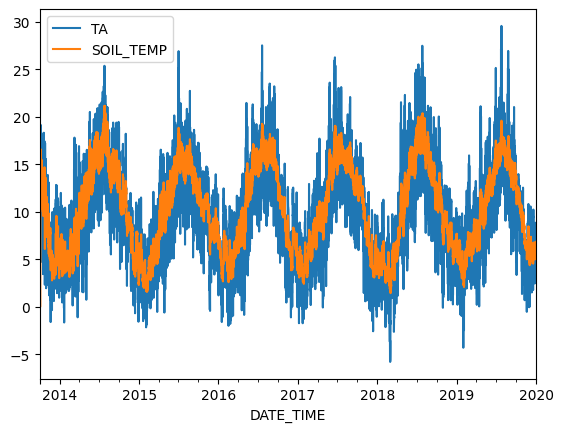

In [28]:
%time ax = df3.groupby('DATE_TIME').mean().compute().plot() 
plt.show()

In [29]:
# Currently we are dividing our data up by the number of initial CSV files:
df3.npartitions

51

In [30]:
df3.memory_usage_per_partition().compute()

0     2266784
1     2734400
2     1913600
3     2020448
4     2444288
5     3171968
6     1433792
7     2595072
8     2004832
9     2074112
10    3425376
11    1327520
12    3411392
13    1348448
14    2021760
15    3922752
16    2180352
17    1488576
18    2665984
19    1746272
20    1847296
21    3980608
22    3164480
23     791200
24    2827456
25    1955520
26    1455840
27    3173760
28    2734560
29    2774880
30    2062080
31    3050016
32    1099584
33    2162368
34    2210880
35    3215552
36    3501824
37    2161696
38     984576
39    2373120
40    1431552
41    3959808
42    2783232
43    2328576
44    1758720
45    1672704
46    2646528
47    3524672
48    1008224
49    3357088
50    1724800
dtype: int64

We can, instead, divide up the data by the frequency of measurements, which is 1/30 minutes.<br>
However, that would be *really* slow! It is __not__ a good idea. In Dask we want a large enough number of partitions that each fits comfortably in memory, but we don't want too many partitions as many operations will scale relative to this number, but in this case `df4.npartitions` would be 87648 (2 * the number of hours in 5 years).
Let's, instead, divide the data by a daily data range.

In [31]:
divisions = tuple(pd.date_range(start='2015', end='2020', freq='1d'))
len(divisions)

1827

In [32]:
del df2, df3

Now, we're using HPC, so let's be a bit more clever with how we distribute the work. We have 72 workers, so let's make the number of partitions a managable multiple of the number of workers.

In [33]:
# A quarter of the number of partitions as a multiple of 72
npart = (72 * (len(divisions) % 72)) // 4
npart

486

In [34]:
df4 = dd.read_csv('/work/m22oc/m22oc/shared/DAwHPC/practicals_data/P3/*2019.csv', usecols=cols, dtype=dtypes, parse_dates=['DATE_TIME']).replace(-9999,np.nan).set_index('DATE_TIME',divisions=divisions)
df4['SOIL_TEMP'] = df4[['TDT1_TSOIL','TDT2_TSOIL']].mean(axis=1)
df4 = df4.drop(columns=['TDT1_TSOIL','TDT2_TSOIL'])

In [35]:
df4.compute()

,SITE_ID,TA,SOIL_TEMP
DATE_TIME,,,
2015-01-01 00:00:00+00:00,BALRD,9.450,1.235
2015-01-01 00:00:00+00:00,CHIMN,6.266,2.895
2015-01-01 00:00:00+00:00,SHEEP,5.933,3.395
2015-01-01 00:00:00+00:00,LULLN,5.253,4.040
2015-01-01 00:00:00+00:00,NWYKE,10.280,4.100
...,...,...,...
2020-01-01 00:00:00+00:00,CHIMN,6.405,6.570
2020-01-01 00:00:00+00:00,LULLN,4.349,6.830
2020-01-01 00:00:00+00:00,SHEEP,5.191,6.465


In [36]:
df4 = df4.persist()

In [37]:
df4.npartitions

1826

The dataframe is now set up for daily data, but the data itself is still hourly.<br>
Now we will resample the data to daily, where the daily values are the mean of the hourly values within that day.

AttributeError: 'DataFrame' object has no attribute 'compute'

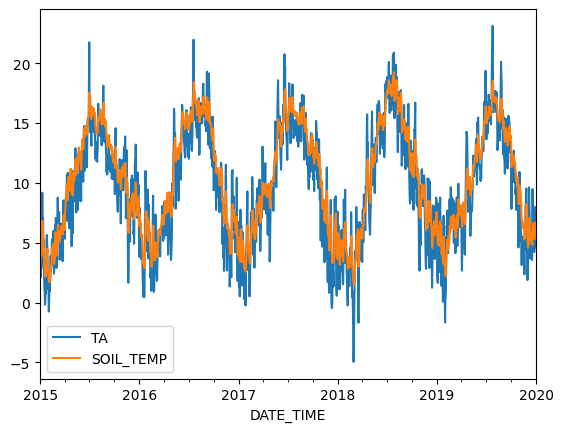

In [40]:
%time df4 = df4[:].resample('1d').mean().compute()
ax = df4.plot()
plt.show()
